In [44]:
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.preprocessing import LabelEncoder

from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import DecomposeResult
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.metrics import MeanAbsolutePercentageError
from sklearn.model_selection import train_test_split

from prophet import Prophet
import warnings

warnings.filterwarnings('ignore')

In [45]:
register_matplotlib_converters()
sns.set_style("darkgrid")
plt.rc("figure", figsize=(16, 12))
plt.rc("font", size=13)

In [46]:
df1 = pd.read_csv('./data/shop_1_transactions.csv', sep=';')
df1['date'] = pd.to_datetime(df1['date'])

# Utils functions


In [47]:
def z_score_pos_filter(df: pd.DataFrame, key: str, z: float = 2.5) -> pd.DataFrame:
    """
    Returns the filtered data with the zscore method. The mean and
    std are evaluated on the > 0 and only the >= 0 rows are kept.
    """
    pos_rows = df[df[key] > 0][key]
    mean, std = pos_rows.mean(), pos_rows.std()
    return df[(df[key] >= 0) & ((df[key] == 0) | ((df[key] - mean)/std < z))].copy()


def split_groupped_data_to_slices(df, input_time_steps, output_time_steps, input_cols, target_col, replacer=0):
    """
    Split the data in a fixed window size to feed model with fixed input size.
    """
    # Calculate the total number of entries in the DataFrame
    num_entries = len(df)

    # Calculate the valid starting indices for each slice
    time_steps = input_time_steps + output_time_steps
    valid_sampling_locations = [time_steps +
                                i for i in range(num_entries - time_steps + 1)]

    # Initialize empty lists for inputs, outputs, time information, and identifiers
    inputs_list, outputs_list = [], []

    # Loop over each valid starting index and extract relevant information for each slice
    for start_idx in valid_sampling_locations:
        # Slice the DataFrame to extract the relevant rows
        sliced = df.iloc[start_idx - time_steps:start_idx]

        # Extract inputs, outputs, time information, and identifiers from the sliced DataFrame
        X = sliced[input_cols+target_col].to_numpy()

        # getting the value to predict
        Y = np.copy(X[-output_time_steps:, -1:])

        # putting 0 in place of the value we want
        # to forecast (in the x single data entry)
        X[-output_time_steps:, -1:] = replacer

        # Append the extracted information to the appropriate list
        inputs_list.append(X)
        outputs_list.append(Y)

    # Return a tuple containing the four lists of extracted information
    return inputs_list, outputs_list,


def numpy_normalised_quantile_loss(y, y_pred, quantile):
    """Computes normalised quantile loss for numpy arrays.
    Uses the q-Risk metric as defined in the "Training Procedure" section of the
    main TFT paper.
    Args:
      y: Targets
      y_pred: Predictions
      quantile: Quantile to use for loss calculations (between 0 & 1)
    Returns:
      Float for normalised quantile loss.
    """
    prediction_underflow = y - y_pred
    weighted_errors = quantile * np.maximum(prediction_underflow, 0.) \
        + (1. - quantile) * np.maximum(-prediction_underflow, 0.)

    quantile_loss = weighted_errors.mean()
    normaliser = y.abs().mean()

    return 2 * quantile_loss / normaliser

# Calendar data


In [48]:
def get_calendar_data():
    # request the json file with all of the calendar events in France
    res = requests.get(
        'https://calendrier.api.gouv.fr/jours-feries/metropole.json')

    # convert the data to a dataframe
    df = pd.DataFrame.from_dict(res.json(), orient='index')
    df.columns = ['calendar_event']

    # parse the date index
    df.index = pd.to_datetime(df.index)
    df.index.name = 'date'

    # resample by day and fill the missing values
    df = df.resample('D').first().fillna("")

    # use the label encoder to convert to numerical values.
    le = LabelEncoder()
    le.fit(df['calendar_event'])
    df['calendar_embedding'] = le.transform(df['calendar_event'])

    # return also the label encoder for parsing
    return df, le


calendar_df, calendar_encoder = get_calendar_data()
calendar_df

,calendar_event,calendar_embedding
date,,
2003-01-01,1er janvier,3
2003-01-02,,0
2003-01-03,,0
2003-01-04,,0
2003-01-05,,0
...,...,...
2028-12-21,,0
2028-12-22,,0
2028-12-23,,0


In [49]:
def get_weekdays_info(date_range: pd.Series):
    # create a dataframe based on the provided date range
    df = pd.DataFrame(index=pd.to_datetime(date_range))

    # extract all of the informations relevant to the date range
    df['weekday'] = df.index.weekday
    df['day_of_week'] = df.index.weekday
    df['day_of_month'] = df.index.day
    df['month'] = df.index.month
    df['year'] = df.index.year

    return df


get_weekdays_info(calendar_df.reset_index()['date'])

,weekday,day_of_week,day_of_month,month,year
date,,,,,
2003-01-01,2,2,1,1,2003
2003-01-02,3,3,2,1,2003
2003-01-03,4,4,3,1,2003
2003-01-04,5,5,4,1,2003
2003-01-05,6,6,5,1,2003
...,...,...,...,...,...
2028-12-21,3,3,21,12,2028
2028-12-22,4,4,22,12,2028
2028-12-23,5,5,23,12,2028


# Weather


In [50]:
# source:
# https://www.historique-meteo.net/
def get_weather_file(filename):
    # Define the key_mapper dictionary
    key_mapper = {
        "DATE": 'date',
        # minimum temperature in degrees Celsius.
        "MIN_TEMPERATURE_C": 'temp_min',
        # maximum temperature in degrees Celsius.
        "MAX_TEMPERATURE_C": 'temp_max',
        # the temperature at noon in degrees Celsius.
        "TEMPERATURE_NOON_C": 'temp_avg',
        # total precipitation for the day in millimeters.
        "PRECIP_TOTAL_DAY_MM": 'rain',
        # the maximum humidity for the day as a percentage.
        "HUMIDITY_MAX_PERCENT": 'humidity',
        # maximum wind speed for the day in kilometers per hour.
        "WINDSPEED_MAX_KMH": 'wind',
        # the average cloud cover for the day as a percentage.
        "CLOUDCOVER_AVG_PERCENT": 'cloud_cov'
    }

    # Read the csv file and map the column names
    df = pd.read_csv(filename, sep=',')
    df = df.rename(columns=key_mapper)
    df = df[list(key_mapper.values())]

    df['date'] = pd.to_datetime(df['date'])

    return df.set_index('date')


weather_df = get_weather_file('./data/shop_1_weather.csv')
weather_df

,temp_min,temp_max,temp_avg,rain,humidity,wind,cloud_cov
date,,,,,,,
2009-01-01,-5,1,1,0.0,90,10,12.000
2009-01-02,-5,1,0,0.1,91,9,46.000
2009-01-03,-4,1,1,0.1,97,13,32.625
2009-01-04,-4,1,1,0.0,91,19,53.125
2009-01-05,-1,0,0,6.0,98,28,98.250
...,...,...,...,...,...,...,...
2023-04-26,3,12,10,0.0,74,9,47.750
2023-04-27,8,18,16,0.2,87,13,67.625
2023-04-28,13,18,16,1.0,97,22,83.875


# Preparing the data for input


In [51]:
def get_daily_ts(df, number_of_items=10) -> dict[str, pd.DataFrame]:
    """
    Extract daily time series from the data 
    """
    # get the list of the 10 most popular items
    popular_item_ids = df.groupby(
        ['item_id'])['quantity'].sum().sort_values(ascending=False).index

    result = {}
    for k in range(number_of_items):
        # load the sales of the most popular item
        item_df = df[df['item_id'] == popular_item_ids[k]]

        # remove outlierz with the zscore method
        item_df = item_df[np.abs(zscore(item_df['quantity'])) < 2]

        # get the data grouped by day
        ts = item_df.set_index('date').resample('D')[['quantity']].sum()
        result[popular_item_ids[k]] = ts

    return result

In [52]:
def remove_empty_weeks(df, col, limit=4):
    """
    Removes entire from the data where there has been less that 4 days of sales.
    """
    df['_weekindex'] = df['date'].dt.isocalendar().week.astype(
        'str') + '-' + df['date'].dt.year.astype('str')

    # remove empty weeks of data and weeks with limited amount of
    # information
    return df.groupby('_weekindex').filter(
        lambda x:  True if len(x) < 7 else (
            x[col].sum() > 0 and
            len(x[x[col] > 0]) > limit
        )
    ).reset_index(drop=True)

In [53]:
calendar_df.index = calendar_df.index.date
weather_df.index = weather_df.index.date

In [54]:
INPUT_COLUMNS = ['weekday', 'day_of_week', 'day_of_month', 'month', 'year',
                 'calendar_embedding', 'temp_min', 'temp_max', 'rain', 'wind', 'cloud_cov']
OUTPUT_COLUMN = ['quantity']
INPUT_TIME_STEPS = 4*7
OUTPUT_TIME_STEPS = 7

In [105]:
def prepare_data(df: pd.DataFrame):
    """
    Format all of the data, to prepare it for the processing by the model
    """
    # extract the time series for the most popular items.
    data = get_daily_ts(df)

    global calendar_df, weather_df

    total_data = []
    # iterate over each time series
    for item_id, ts in data.items():
        ts = remove_empty_weeks(
            ts.reset_index(), OUTPUT_COLUMN[0]
        )

        # merge all of the data together, start by extracting the weekday column
        weekday_df = get_weekdays_info(ts['date'])
        weekday_df.index = weekday_df.index.date
        ts.index = ts['date'].dt.date

        # inner join on the target column (ie keep all of the target rows and drop extra rows.)
        ts_df = pd.concat([ts, weekday_df, calendar_df, weather_df], axis=1)
        ts_df = ts_df.dropna(subset=OUTPUT_COLUMN)

        # convert the output to log scale
        ts_df[OUTPUT_COLUMN] = np.log(ts_df[OUTPUT_COLUMN] + 1)

        # add the data
        ts_df['item_id'] = item_id
        total_data.append(ts_df)

    # merge all of the data together
    return pd.concat(total_data)

In [99]:
def convert_to_model_inputs(df, placeholder):
    """
    Convert the data from a dataframe to numpy input which can be fed to the model.
    """
    inputs, outputs = [], []
    for _, ts_df in df.groupby('item_id'):
        # convert the data to model inputs and outputs
        X, Y = split_groupped_data_to_slices(
            ts_df,
            input_time_steps=INPUT_TIME_STEPS,
            output_time_steps=OUTPUT_TIME_STEPS,
            input_cols=INPUT_COLUMNS,
            target_col=OUTPUT_COLUMN,
            replacer=placeholder
        )
        inputs.extend(X)
        outputs.extend(Y)

    return np.array(inputs), np.array(outputs)

In [106]:
# extract the time series for the most popular items.
total_df = prepare_data(df1)

# scale the target
target_scaler = StandardScaler()
total_df[OUTPUT_COLUMN] = target_scaler.fit_transform(total_df[OUTPUT_COLUMN])

# scale the covariates
covariates_scaler = StandardScaler()
total_df[INPUT_COLUMNS] = covariates_scaler.fit_transform(
    total_df[INPUT_COLUMNS])

# this placeholder value is used to replace the values we want to forecast when we 
# feed the data to the model.
placeholder = target_scaler.transform([[0]])
inputs, outputs = convert_to_model_inputs(total_df, placeholder=placeholder)

# Model 1: Deep Learning


In [107]:
X_train, X_test, y_train, y_test = train_test_split(
    inputs, outputs, test_size=0.2, random_state=42)

In [108]:
f'Number of training samples: {X_train.shape[0]}'

'Number of training samples: 10423'

In [85]:
model = Sequential()

model.add(LSTM(64, activation='relu', return_sequences=True,
          input_shape=inputs.shape[1:]))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dense(16))
model.add(Dense(7))

model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 35, 64)            19712     
                                                                 
 lstm_9 (LSTM)               (None, 32)                12416     
                                                                 
 dense_8 (Dense)             (None, 16)                528       
                                                                 
 dense_9 (Dense)             (None, 7)                 119       
                                                                 
Total params: 32,775
Trainable params: 32,775
Non-trainable params: 0
_________________________________________________________________


In [86]:
model.fit(X_train, y_train, epochs=50, verbose=1, validation_split=0.2)

Epoch 1/50
261/261 [==============================] - 4s 11ms/step - loss: 0.8432 - val_loss: 0.7073
Epoch 2/50
261/261 [==============================] - 3s 11ms/step - loss: 0.5259 - val_loss: 0.2932
Epoch 3/50
261/261 [==============================] - 3s 11ms/step - loss: 0.2066 - val_loss: 0.1771
Epoch 4/50
261/261 [==============================] - 3s 11ms/step - loss: 0.1737 - val_loss: 0.1719
Epoch 5/50
261/261 [==============================] - 3s 11ms/step - loss: 0.1607 - val_loss: 0.1509
Epoch 6/50
261/261 [==============================] - 3s 11ms/step - loss: 0.1485 - val_loss: 0.1411
Epoch 7/50
261/261 [==============================] - 3s 11ms/step - loss: 0.1382 - val_loss: 0.1308
Epoch 8/50
261/261 [==============================] - 3s 11ms/step - loss: 0.1311 - val_loss: 0.1273
Epoch 9/50
261/261 [==============================] - 3s 11ms/step - loss: 0.1250 - val_loss: 0.1349
Epoch 10/50
261/261 [==============================] - 3s 11ms/step - loss: 0.1207 - val_lo

In [103]:
# evaluate the forecast and inverse transform the data
y_pred = np.exp(target_scaler.inverse_transform(model.predict(X_test))) - 1
y_true = np.exp(target_scaler.inverse_transform(
    np.reshape(y_test, y_pred.shape))) - 1

82/82 [==============================] - 0s 3ms/step


In [75]:
def mape(y_true, y_pred):
    mask = y_true != 0
    y_true = y_true[mask]
    y_pred = y_pred[mask]
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

In [89]:
mape(y_true, y_pred)

30.488880357381408

In [104]:
mae(y_true, y_pred)

4.585845840678927

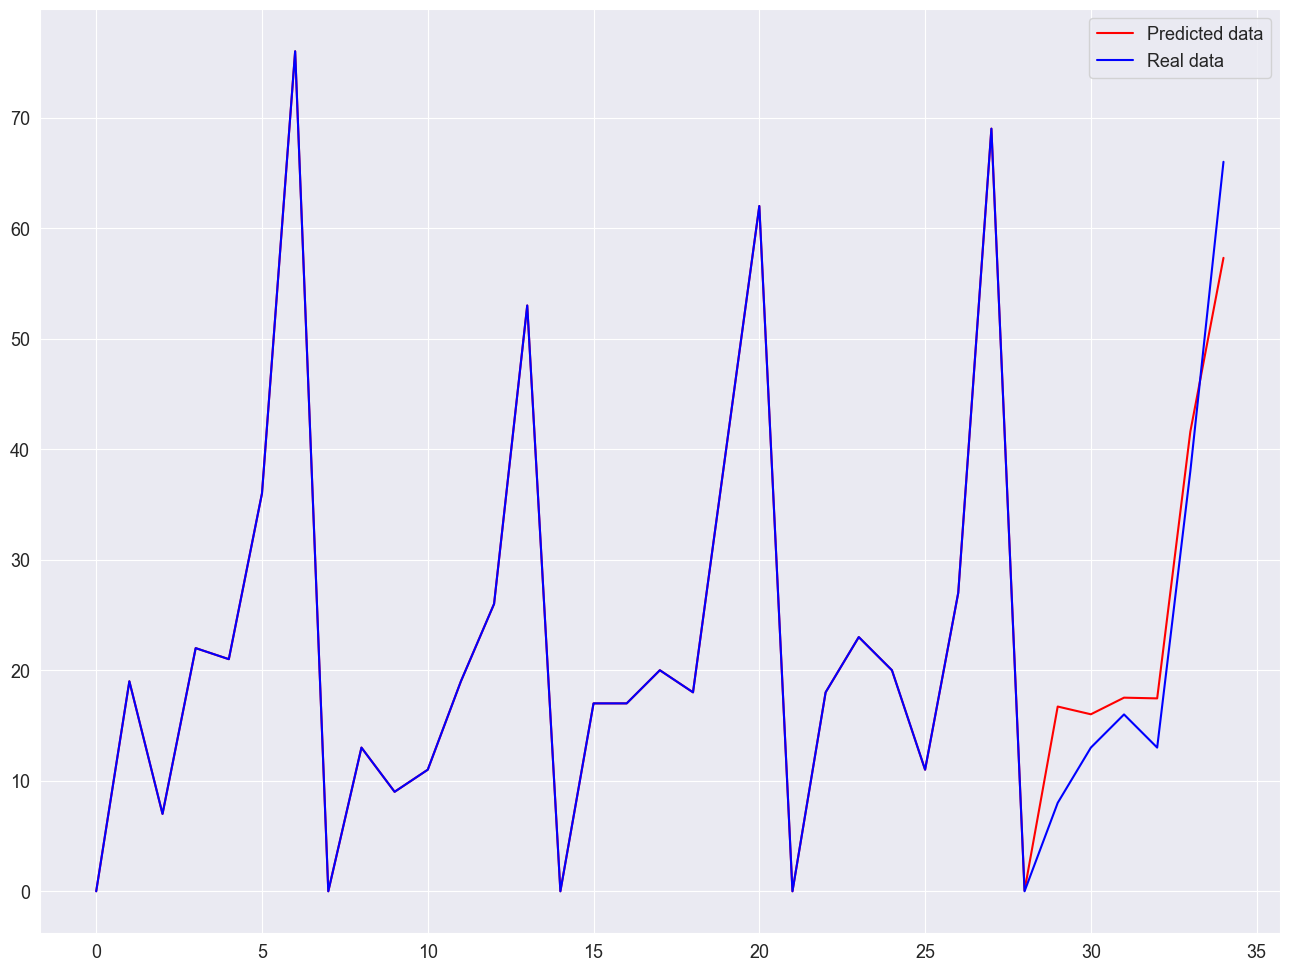

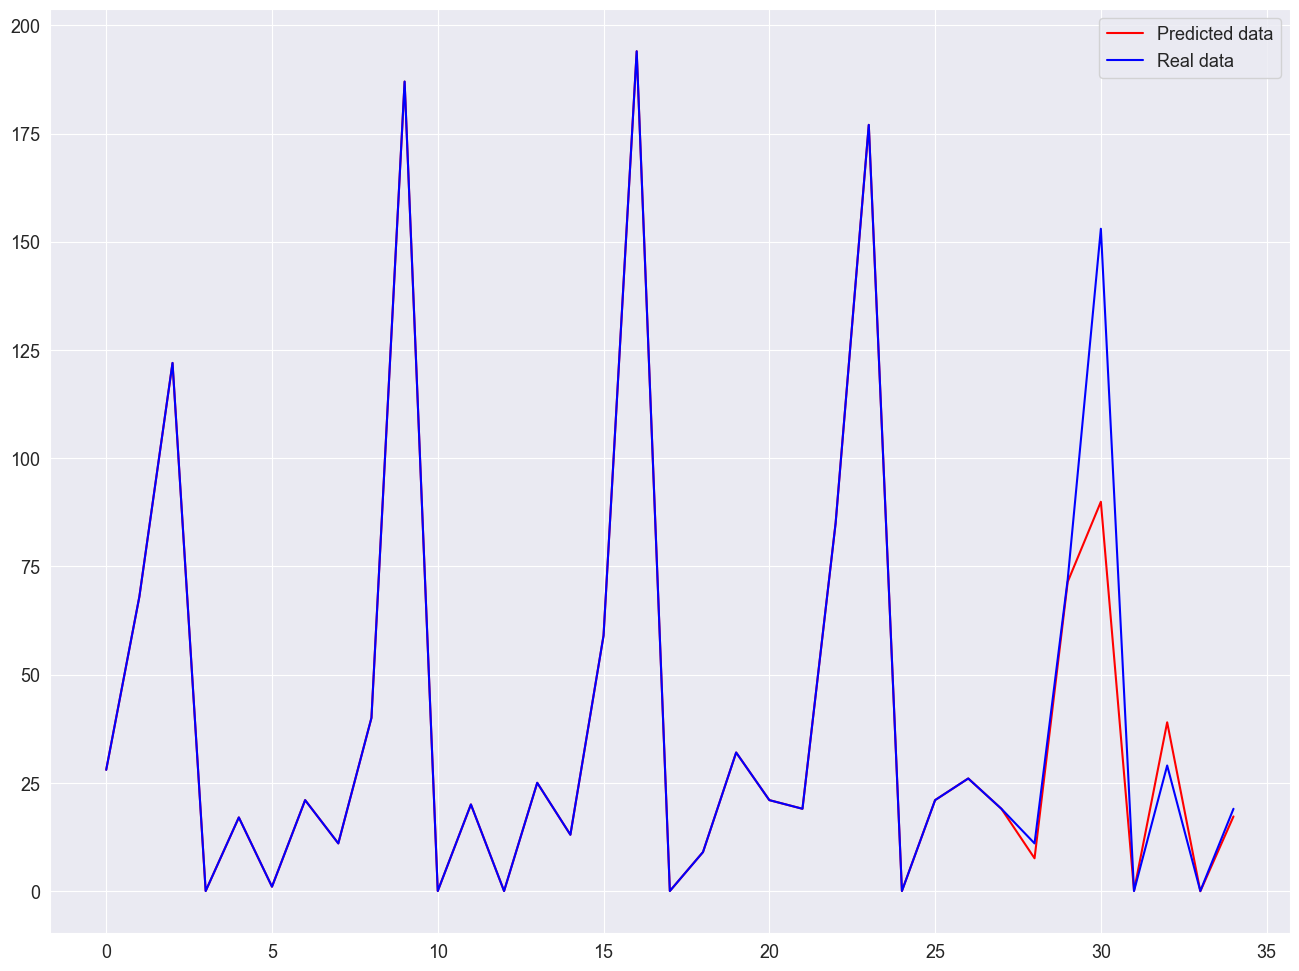

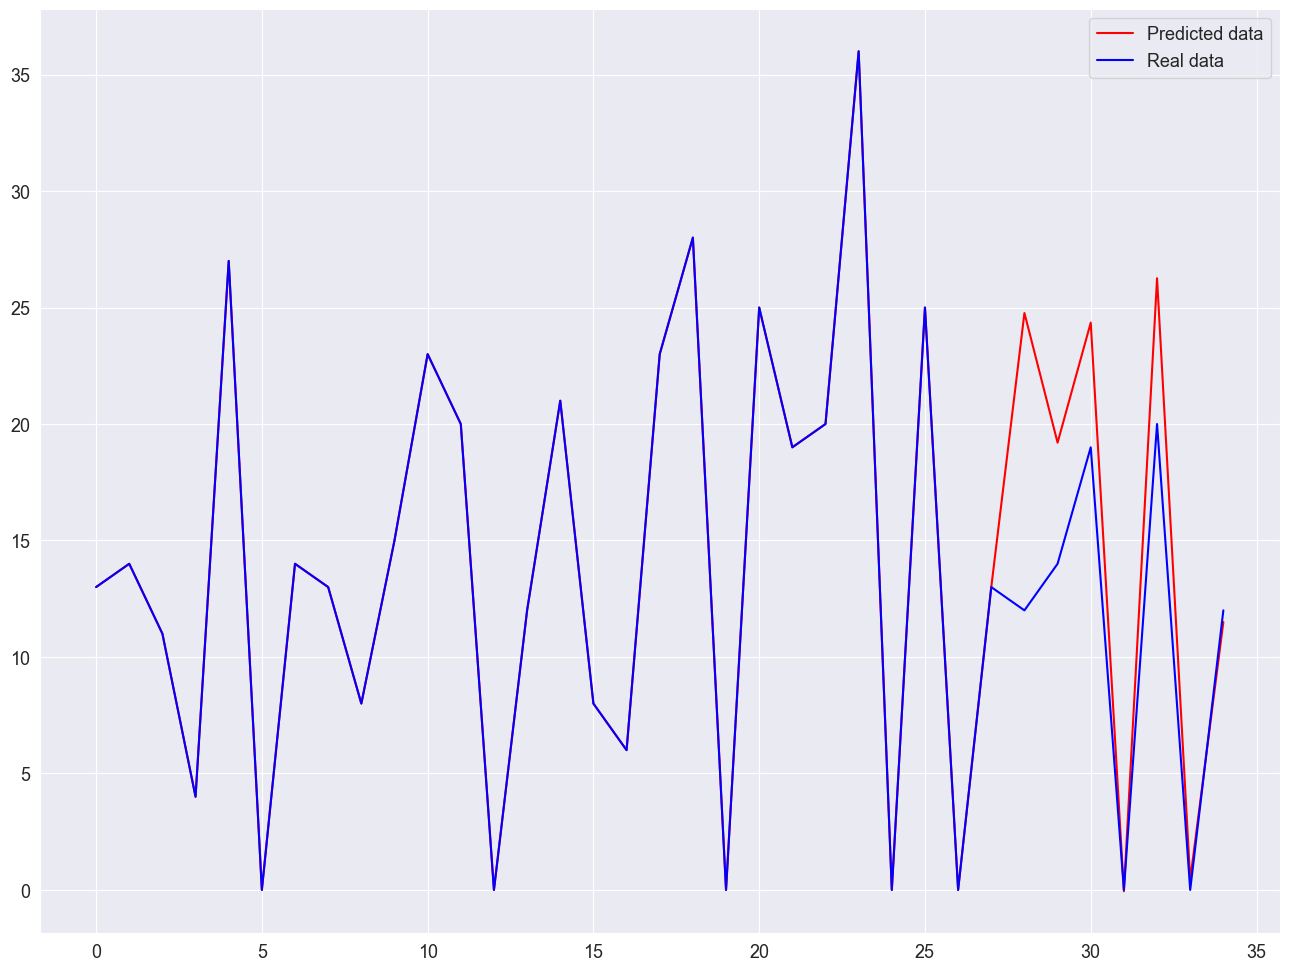

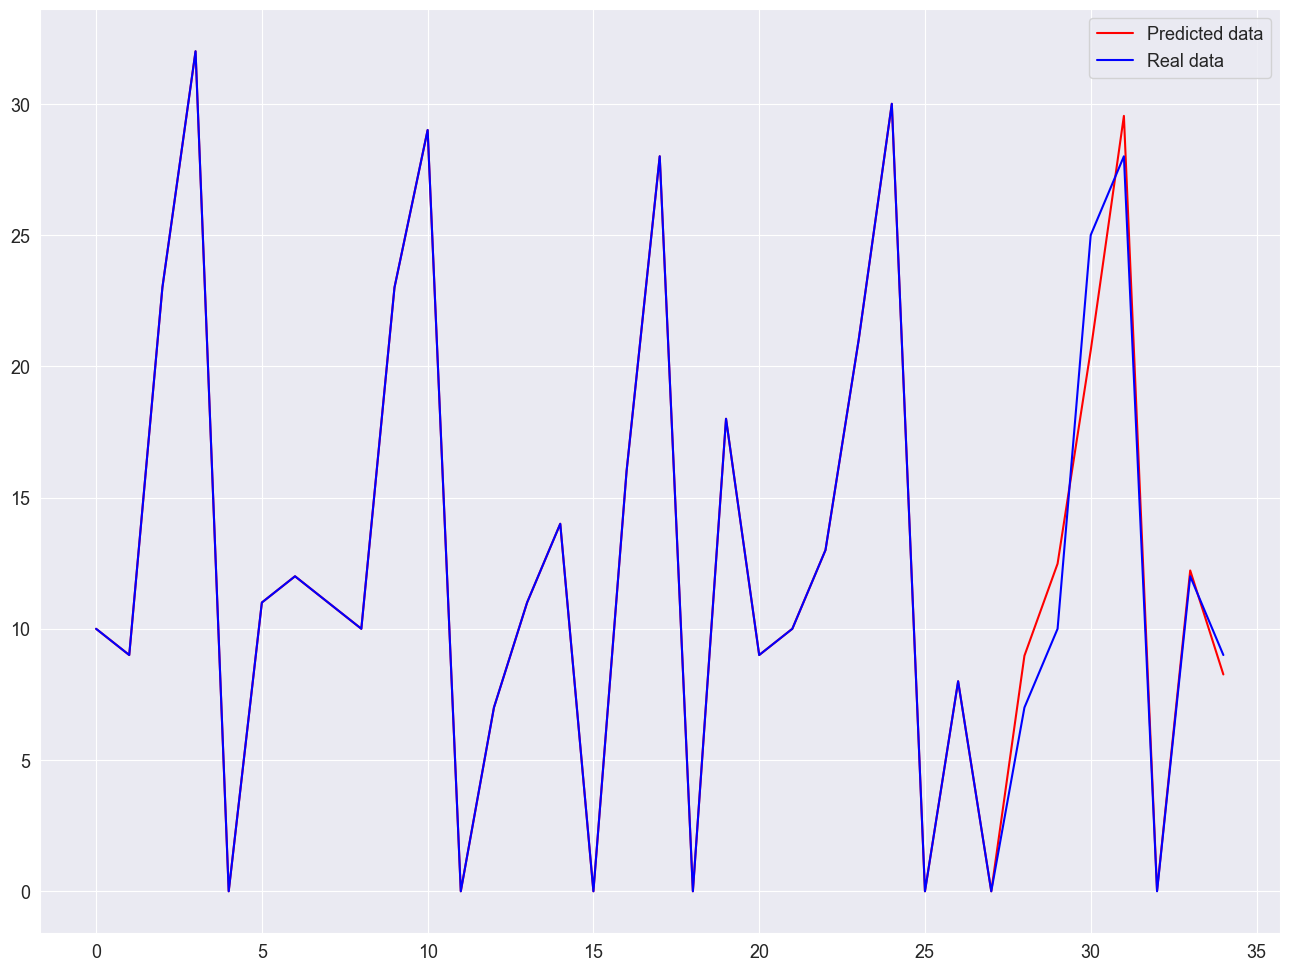

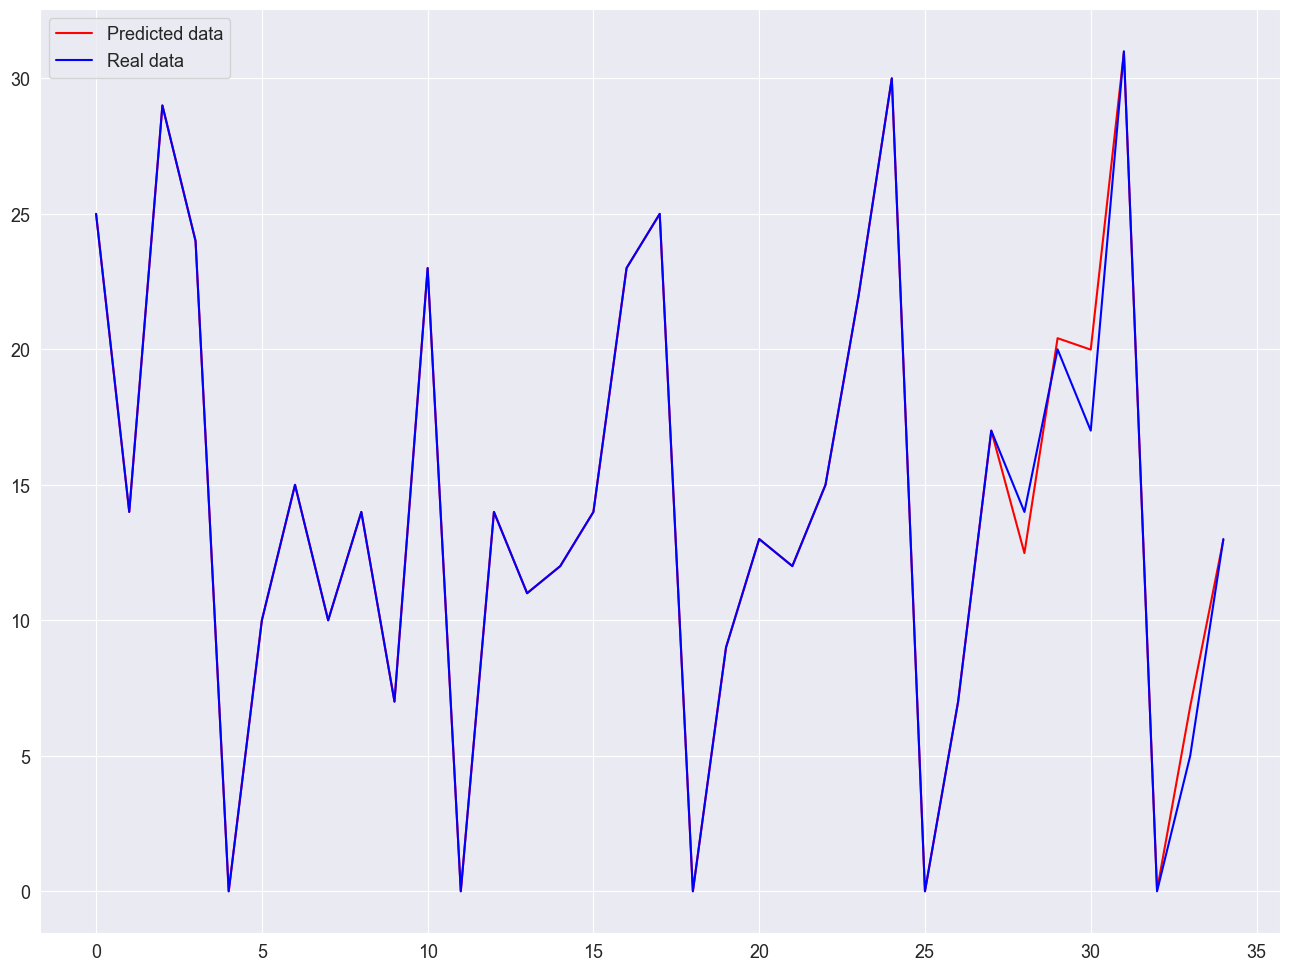

In [96]:
for k in range(5):
    prev_ts = np.exp(target_scaler.inverse_transform(
        X_test[k, :-OUTPUT_TIME_STEPS, -1].reshape(1, -1))) - 1
    plt.plot(prev_ts.flatten().tolist() +
             y_pred[k, :].tolist(), color='r', label='Predicted data')
    plt.plot(prev_ts.flatten().tolist() +
             y_true[k, :].tolist(), color='b', label='Real data')
    plt.legend()
    plt.show()

# Testing the model on the second shop data

In [109]:
df2 = pd.read_csv('./data/shop_1_transactions.csv', sep=';')
df2['date'] = pd.to_datetime(df2['date'])

weather_df = get_weather_file('./data/shop_2_weather.csv')

In [117]:
# extract the time series for the most popular items.
total_df_2 = prepare_data(df2).fillna(0)

# scale the target
total_df_2[OUTPUT_COLUMN] = target_scaler.transform(total_df_2[OUTPUT_COLUMN])

# scale the covariates
total_df_2[INPUT_COLUMNS] = covariates_scaler.transform(total_df_2[INPUT_COLUMNS])

# prepare the data for the model
inputs_2, outputs_2 = convert_to_model_inputs(total_df_2, placeholder=placeholder)

In [119]:
# evaluate the forecast and inverse transform the data
y_pred_2 = np.exp(target_scaler.inverse_transform(model.predict(inputs_2))) - 1
y_true_2 = np.exp(target_scaler.inverse_transform(
    np.reshape(outputs_2, y_pred_2.shape))) - 1

408/408 [==============================] - 1s 3ms/step


In [120]:
mape(y_true_2,y_pred_2)

28.496184023683202

In [121]:
mae(y_true_2,y_pred_2)

4.34010621929946

# Model 2: Prophet - Probabilistic model


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -252.801
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1822.07    0.00102769       64.6171      0.3126           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     138       1822.12   9.48027e-05       81.7737   1.664e-06       0.001      208  LS failed, Hessian reset 
     183       1822.12   1.28137e-07       56.5705      0.5607           1      269   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


<Axes: xlabel='ds', ylabel='y'>

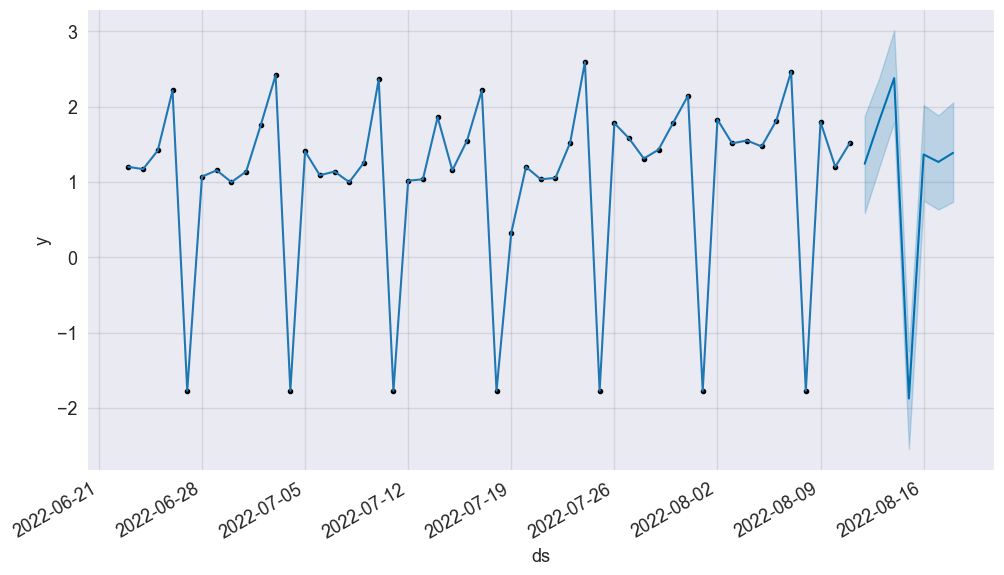

In [83]:
# prepare the data for the prophet model
main_ts = total_df[total_df['item_id'] == 'IT-11'].copy()
# the ds column provide the library with date timestamp info.
main_ts['ds'] = main_ts.index
# the target variable, note that here the data is still in log scale and normalized.
main_ts['y'] = main_ts[OUTPUT_COLUMN[0]]
# fillna with zero in case of missing values.
main_ts = main_ts.fillna(0)

# load the model and add covariates
m = Prophet()
for cov in INPUT_COLUMNS:
    m.add_regressor(cov)

# fit the model on all of the data but the last seven rows for forecasting.
m.fit(main_ts.head(len(main_ts) - 7))

# predict the last seven days
fcst = m.predict(main_ts.tail(7))
# for visualisation purposes.
m.history = m.history.tail(50)
# plot the forecast along with the confidence interval.
m.plot(fcst)
m.history.set_index('ds')['y'].plot()